In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from functools import partial
np.set_printoptions(suppress=True)
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import binom

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf

In [4]:
from deep_bayes.models import BayesFlow, InvariantNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# Load Germany Data

In [6]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
recovered_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
dead_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'


confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
recovered_cases = pd.read_csv(recovered_cases_url, sep=',')
dead_cases = pd.read_csv(dead_cases_url, sep=',')


date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,5,21)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
recovered_obs =  np.array(
    recovered_cases.loc[recovered_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

dead_obs =  np.array(
    dead_cases.loc[dead_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

data_germany = np.stack([cases_obs, recovered_obs, dead_obs]).T
data_germany = np.diff(data_germany, axis=0)
T = data_germany.shape[0]
N_germany = 83e6
mean_g = np.mean(data_germany, axis=0)
std_g = np.std(data_germany, axis=0)

# Prior and Model

In [7]:
alpha_f = (0.7**2)*((1-0.7)/(0.17**2) - (1-0.7))
beta_f = alpha_f*(1/0.7 - 1)


def prior_sir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    t1 = np.random.normal(loc=8, scale=3)
    t2 = np.random.normal(loc=15, scale=1)
    t3 = np.random.normal(loc=22, scale=1)
    t4 = np.random.normal(loc=66, scale=1) 
    delta_t1 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t2 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t3 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t4 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    lambd0 = np.random.lognormal(mean=np.log(1.2), sigma=0.5)
    lambd1 = np.random.lognormal(mean=np.log(0.6), sigma=0.5)
    lambd2 = np.random.lognormal(mean=np.log(0.3), sigma=0.5)
    lambd3 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    lambd4 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    mu = np.random.lognormal(mean=np.log(1/8), sigma=0.2)
    f_i = np.random.beta(a=alpha_f, b=beta_f)
    phi_i = stats.vonmises(kappa=0.01).rvs()
    f_r = np.random.beta(a=alpha_f, b=beta_f)
    phi_r = stats.vonmises(kappa=0.01).rvs()
    f_d = np.random.beta(a=alpha_f, b=beta_f)
    phi_d = stats.vonmises(kappa=0.01).rvs()
    D_i = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_r = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_d = np.random.lognormal(mean=np.log(8), sigma=0.2)
    E0 = np.random.gamma(shape=2, scale=30)
    scale_I = np.random.gamma(shape=1, scale=5)
    scale_R = np.random.gamma(shape=1, scale=5)
    scale_D = np.random.gamma(shape=1, scale=5)
    return [t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, 
            lambd0, lambd1, lambd2, lambd3, lambd4, mu, 
            f_i, phi_i, f_r, phi_r, f_d, phi_d, 
            D_i, D_r, D_d, E0, scale_I, scale_R, scale_D]


def prior_secir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    alpha = np.random.uniform(low=0.005, high=0.9)
    beta = np.random.lognormal(mean=np.log(0.25), sigma=0.3)
    gamma = np.random.lognormal(mean=np.log(1/6.5), sigma=0.5)
    eta = np.random.lognormal(mean=np.log(1/3.2), sigma=0.3)
    theta = np.random.uniform(low=1/14, high=1/3)
    delta = np.random.uniform(low=0.01, high=0.3)
    d = np.random.uniform(low=1/14, high=1/3)
    return [alpha, beta, gamma, eta, theta, delta, d]


def calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                      t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T):
    """Computes the array of time-varying contact rates/transimission probabilities."""
    
    # Array of initial lambdas
    lambd0_arr = np.array([lambd0] * (t1+sim_lag))
    
    # Compute lambd1 array
    if delta_t1 == 1:
        lambd1_arr = np.array([lambd1] * (t2-t1))
    else:
        lambd1_arr = np.linspace(lambd0, lambd1, delta_t1)
        lambd1_arr = np.append(lambd1_arr, [lambd1] * (t2-t1-delta_t1))
        
    # Compute lambd2 array
    if delta_t2 == 1:
        lambd2_arr = np.array([lambd2] * (t3-t2))
    else:
        lambd2_arr = np.linspace(lambd1, lambd2, delta_t2)
        lambd2_arr = np.append(lambd2_arr, [lambd2] * (t3-t2-delta_t2))
        
    # Compute lambd3 array
    if delta_t3 == 1:
        lambd3_arr = np.array([lambd3] * (t4-t3))
    else:
        lambd3_arr = np.linspace(lambd3, lambd4, delta_t3)
        lambd3_arr = np.append(lambd3_arr, [lambd3] * (t4-t3-delta_t3))
        
    # Compute lambd4 array
    if delta_t4 == 1:
        lambd4_arr = np.array([lambd4] * (T-t4))
    else:
        lambd4_arr = np.linspace(lambd3, lambd4, delta_t4)
        lambd4_arr = np.append(lambd4_arr, [lambd4] * (T-t4-delta_t4))
    
    return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr]

    
def non_stationary_SEICR(params_sir, params_secir, N, T, sim_diff=16, observation_model=True):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters 
    t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, f_i, phi_i, f_r, phi_r, f_d, phi_d, delay_i, delay_r, delay_d, E0, scale_I, scale_R, scale_D = params_sir
    alpha, beta, gamma, eta, theta, delta, d = params_secir
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    delta_t1, delta_t2, delta_t3, delta_t4 = int(round(delta_t1)), int(round(delta_t2)), int(round(delta_t3)), int(round(delta_t4))
    E0 = max(1, np.round(E0)) 
    delay_i = int(round(delay_i)) 
    delay_r = int(round(delay_r)) 
    delay_d = int(round(delay_d)) 
    
    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_r
    assert sim_diff > delay_d
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4
    assert delta_t1 > 0 and delta_t2 > 0 and delta_t3 > 0 and delta_t4 > 0
    assert t2 - t1 >= delta_t1 and t3 - t2 >= delta_t2 and t4-t3 >= delta_t3 and T-t4 >= delta_t4

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                                  t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T)
 
    # Initial conditions
    S, E, C, I, R, D = [N-E0], [E0], [0], [0], [0], [0]
    
    # Containers
    I_news = []
    R_news = []
    D_news = []
    
    # Reported new cases
    I_data = np.zeros(T)
    R_data = np.zeros(T)
    D_data = np.zeros(T)
    fs_i = np.zeros(T)
    fs_r = np.zeros(T)
    fs_d = np.zeros(T)
 
    # Simulate T-1 tiemsteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + beta*I[t])/N)*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*theta*C[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        I_new = (1-alpha)*eta*C[t]
        
        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered. The newly recovered are only the detected recovered
        R_t = R[t] + alpha*theta*C[t] + (1-delta)*mu*I[t]
        R_new = (1-delta)*mu*I[t]
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t]
        D_new = delta*d*I[t]
        
        # Ensure some numerical onstraints
        S_t = np.clip(S_t, 0, N)
        E_t = np.clip(E_t, 0, N)
        C_t = np.clip(C_t, 0, N)
        I_t = np.clip(I_t, 0, N)
        R_t = np.clip(R_t, 0, N)
        D_t = np.clip(D_t, 0, N)
        
        # Keep track of process over time
        S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        I_news.append(I_new)
        R_news.append(R_new)
        D_news.append(D_new)
        
        # From here, start adding new cases with delay D
        # Note, we assume the same delay
        if t >= sim_lag:
            
            # Compute lags and add to data arrays
            fs_i[t-sim_lag] = (1-f_i)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_i)) )
            fs_r[t-sim_lag] = (1-f_r)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_r)) )
            fs_d[t-sim_lag] = (1-f_d)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_d)) )
            I_data[t-sim_lag] = I_news[t-delay_i]
            R_data[t-sim_lag] = R_news[t-delay_r]
            D_data[t-sim_lag] = D_news[t-delay_d]
            
    # Compute weekly modulation
    I_data = (1-fs_i) * I_data
    R_data = (1-fs_r) * R_data
    D_data = (1-fs_d) * D_data
    
    # Add noise
    I_data = stats.t(df=4, loc=I_data, scale=np.sqrt(I_data)*scale_I).rvs()
    R_data = stats.t(df=4, loc=R_data, scale=np.sqrt(R_data)*scale_R).rvs()
    D_data = stats.t(df=4, loc=D_data, scale=np.sqrt(D_data)*scale_D).rvs()
    
    if observation_model:
        return np.stack((I_data, R_data, D_data)).T
    return np.stack((S, E, I, C, R, D)).T


def SECIR_asymptomatic(params_sir, params_secir, N, T, sim_diff=16):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters 
    t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, f_i, phi_i, f_r, phi_r, f_d, phi_d, delay_i, delay_r, delay_d, E0, scale_I, scale_R, scale_D = params_sir
    alpha, beta, gamma, eta, theta, delta, d = params_secir
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    delta_t1, delta_t2, delta_t3, delta_t4 = int(round(delta_t1)), int(round(delta_t2)), int(round(delta_t3)), int(round(delta_t4))
    E0 = max(1, np.round(E0)) 
    delay_i = int(round(delay_i)) 
    delay_r = int(round(delay_r)) 
    delay_d = int(round(delay_d)) 
    
    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_r
    assert sim_diff > delay_d
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4
    assert delta_t1 > 0 and delta_t2 > 0 and delta_t3 > 0 and delta_t4 > 0
    assert t2 - t1 >= delta_t1 and t3 - t2 >= delta_t2 and t4-t3 >= delta_t3 and T-t4 >= delta_t4

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                                  t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T)
 
    # Initial conditions
    S, E, C, I, R, D = [N-E0], [E0], [0], [0], [0], [0]
    
    # Containers
    A_data = [0]
    S_data = [0]
 
    # Simulate T-1 tiemsteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + beta*I[t])/N)*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*theta*C[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        I_new = (1-alpha)*eta*C[t]
        
        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered. The newly recovered are only the detected recovered
        R_t = R[t] + alpha*theta*C[t] + (1-delta)*mu*I[t]
        R_new = (1-delta)*mu*I[t]
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t]
        D_new = delta*d*I[t]
        
        # Ensure some numerical onstraints
        S_t = np.clip(S_t, 0, N)
        E_t = np.clip(E_t, 0, N)
        C_t = np.clip(C_t, 0, N)
        I_t = np.clip(I_t, 0, N)
        R_t = np.clip(R_t, 0, N)
        D_t = np.clip(D_t, 0, N)
        
        # Keep track of process over time
        S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        
        # Add the new saymptomatic cases
        A_data.append(alpha*theta*C[t])
        S_data.append((1-alpha)*eta*C[t])
    
    return np.array(A_data), np.array(S_data)

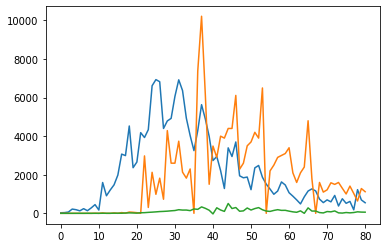

In [8]:
plt.plot(data_germany)

# Data Generator for Neural Net

In [9]:
def data_generator(batch_size, T=None, N=None, T_min=10, T_max=90, sim_diff=21,
                   N_min=10000, N_max=70000000, to_tensor=True, seed=None):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    simulator  : callable -- the data simulator
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    if seed is not None:
        np.random.seed(seed)
        
    # Variable-size t
    if T is None:
        T = np.random.randint(T_min, T_max+1)
    
    # Variable size N
    if N is None:
        N = np.random.randint(N_min, N_max)
        
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    theta = []
    for i in range(batch_size):
        
        # Reject meaningless simulaitons
        x_i = None
        while x_i is None:
            try:
                
                theta1 = prior_sir()
                theta2 = prior_secir()
                x_i = non_stationary_SEICR(theta1, theta2, N, T, sim_diff=sim_diff)
                x_i = (x_i - mean_g) / std_g
            except:
                 pass
        # Simulate SECIR
        x.append(x_i)
        theta.append(theta1 + theta2)
    x = np.array(x)

    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta,  'x': x}

# Training Hyperparameters

In [17]:
# Network hyperparameters
inv_meta = {
    'n_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_summary = 192
n_inv_blocks = 6

param_names = [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$',
               r'$\Delta t_1$', r'$\Delta t_2$', r'$\Delta t_3$', r'$\Delta t_4$',
               r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$', 
               r'$\mu$', r'$f_I$', r'$\phi_I$',  r'$f_R$', r'$\phi_R$',  
               r'$f_D$', r'$\phi_D$',
               r'$L_I$', r'$L_R$', r'$L_D$', r'$E_0$', r'$\sigma_I$', r'$\sigma_R$', r'$\sigma_D$', 
               r'$\alpha$', r'$\beta$', r'$\gamma$',
               r'$\eta$', r'$\theta$', r'$\delta$', r'$d$']

theta_dim = len(param_names)
n_test = 300

# Training and optimizer hyperparameters
ckpt_file = "Germany_AblationConv"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.


starter_learning_rate = 0.0005
decay_steps = 1000
decay_rate = .99
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate, decay_steps, decay_rate, staircase=True, name=None
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [18]:
data_gen = partial(data_generator, T=T, N=N_germany, sim_diff=16)

In [19]:
class RecurrentNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=64):
        super(RecurrentNet, self).__init__()
        
        self.lstm = tf.keras.layers.LSTM(n_filters)
        
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = self.lstm(x)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary):
        super(SummaryNet, self).__init__()
        self.net_I = RecurrentNet(n_filters=n_summary//3)
        self.net_R = RecurrentNet(n_filters=n_summary//3)
        self.net_D = RecurrentNet(n_filters=n_summary//3)
    
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        x = tf.split(x, 3, axis=-1)
        x_i = self.net_I(x[0])
        x_r = self.net_R(x[1])
        x_d = self.net_D(x[2])
        return tf.concat([x_i, x_r, x_d], axis=-1)

In [20]:
summary_net = SummaryNet(n_summary)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

In [21]:
%%time
test_data = data_gen(n_test)

Wall time: 4.85 s


In [22]:
data_germany_tensor = tf.convert_to_tensor(data_germany[np.newaxis], dtype=tf.float32)

In [23]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}/'.format(ckpt_file), max_to_keep=20)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/Germany_AblationConv/ckpt-75


In [45]:
%%time
for ep in range(1, 25+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='global_norm')
        
        # Manage checkpoint
        manager.save()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 5h 48min 9s, sys: 1min 13s, total: 5h 49min 23s
Wall time: 5h 44min 8s


# Publication figures

## Univariate parameter posteriors

In [32]:
from sklearn.neighbors import KernelDensity

def estimate_map(samples):
    
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    scores = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1)).score_samples(samples.reshape(-1, 1))
    max_i = scores.argmax()
    map_i = samples[max_i]
    return map_i


def get_kde(samples):
    """Returns sorted kdes."""
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    kde = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1))
    x_plot = np.linspace(samples.min(), samples.max(), 10000)
    y_plot = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
    return x_plot, y_plot

def plot_posteriors_germany(n_samples, 
                            data, 
                            figsize=(22, 12), 
                            font_size=16, 
                            filename=None, 
                            bins=30,
                            map_samples=5000):
    """Plots univariate posteriors."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    norm_data = (data - mean_g) / std_g 
    samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$' and e != '$\\phi_R$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    idx_alpha = param_names.index('$\\alpha$')
    print('Number of valid samples: ', samples.shape[0])
    f, ax = plt.subplots(6, 6, figsize=figsize)
    for i in range(theta_dim):
        
        
        x_fill, y_fill = get_kde(prior_samples[:, i])
        ax.flat[i].plot(x_fill, y_fill, alpha=0.5, color='gray', lw=3, label='Prior')
        sns.histplot(samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='#a34f4f', element='step', label='Posterior')
        
        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed')
        ax.flat[i].set_title(param_names[i], pad=0.4)
        ax.flat[i].set_ylim([0, ax.flat[i].get_ylim()[1]])
        if i == idx_alpha:
            align = 'right'
            xx = 0.4
        else:
            align = 'left'
            xx = 0.7
            
        # Change points
        if i < 4:
            
            tick_std = np.std(prior_samples[:, i])
            tick_mean = np.mean(prior_samples[:, i])
            ax.flat[i].set_xticks([tick_mean-1.98*tick_std, tick_mean, tick_mean+1.98*tick_std])
            ax.flat[i].set_xticklabels([days[int(round(tick_mean - 1.98*tick_std))], 
                                        days[int(round(tick_mean))], 
                                        days[int(round(tick_mean + 1.98*tick_std))]], rotation=30)
            
        if i == 0:
            lg = f.legend(loc='lower right', bbox_to_anchor=(0.9, 0.04), 
                     ncol=2, fontsize=20, borderaxespad=1)
            
        med = np.median(samples[:, i])
        MAP = estimate_map(samples[:map_samples, i])
        ax.flat[i].text(xx, 0.85, r'$MAP={:.2f}$'.format(MAP),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        ax.flat[i].text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        
        ax.flat[i].set_ylabel('')
        ax.flat[i].set_yticks([])
        
    ax.flat[i+1].axis('off')
    ax.flat[i+2].axis('off')
    f.tight_layout()
    plt.show()
    
     # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300,  
                  bbox_extra_artists=(lg,), bbox_inches='tight')

In [46]:
days = ['March {}'.format(i) for i in range(1, 32)] + \
       ['April {}'.format(i) for i in range (1, 31)] + \
       ['May {}'.format(i) for i in range(1, 21)]

In [47]:
n_prior_samples = 5000
prior_samples = np.array([prior_sir() + prior_secir() for _ in range(n_prior_samples)])

Number of valid samples:  47615


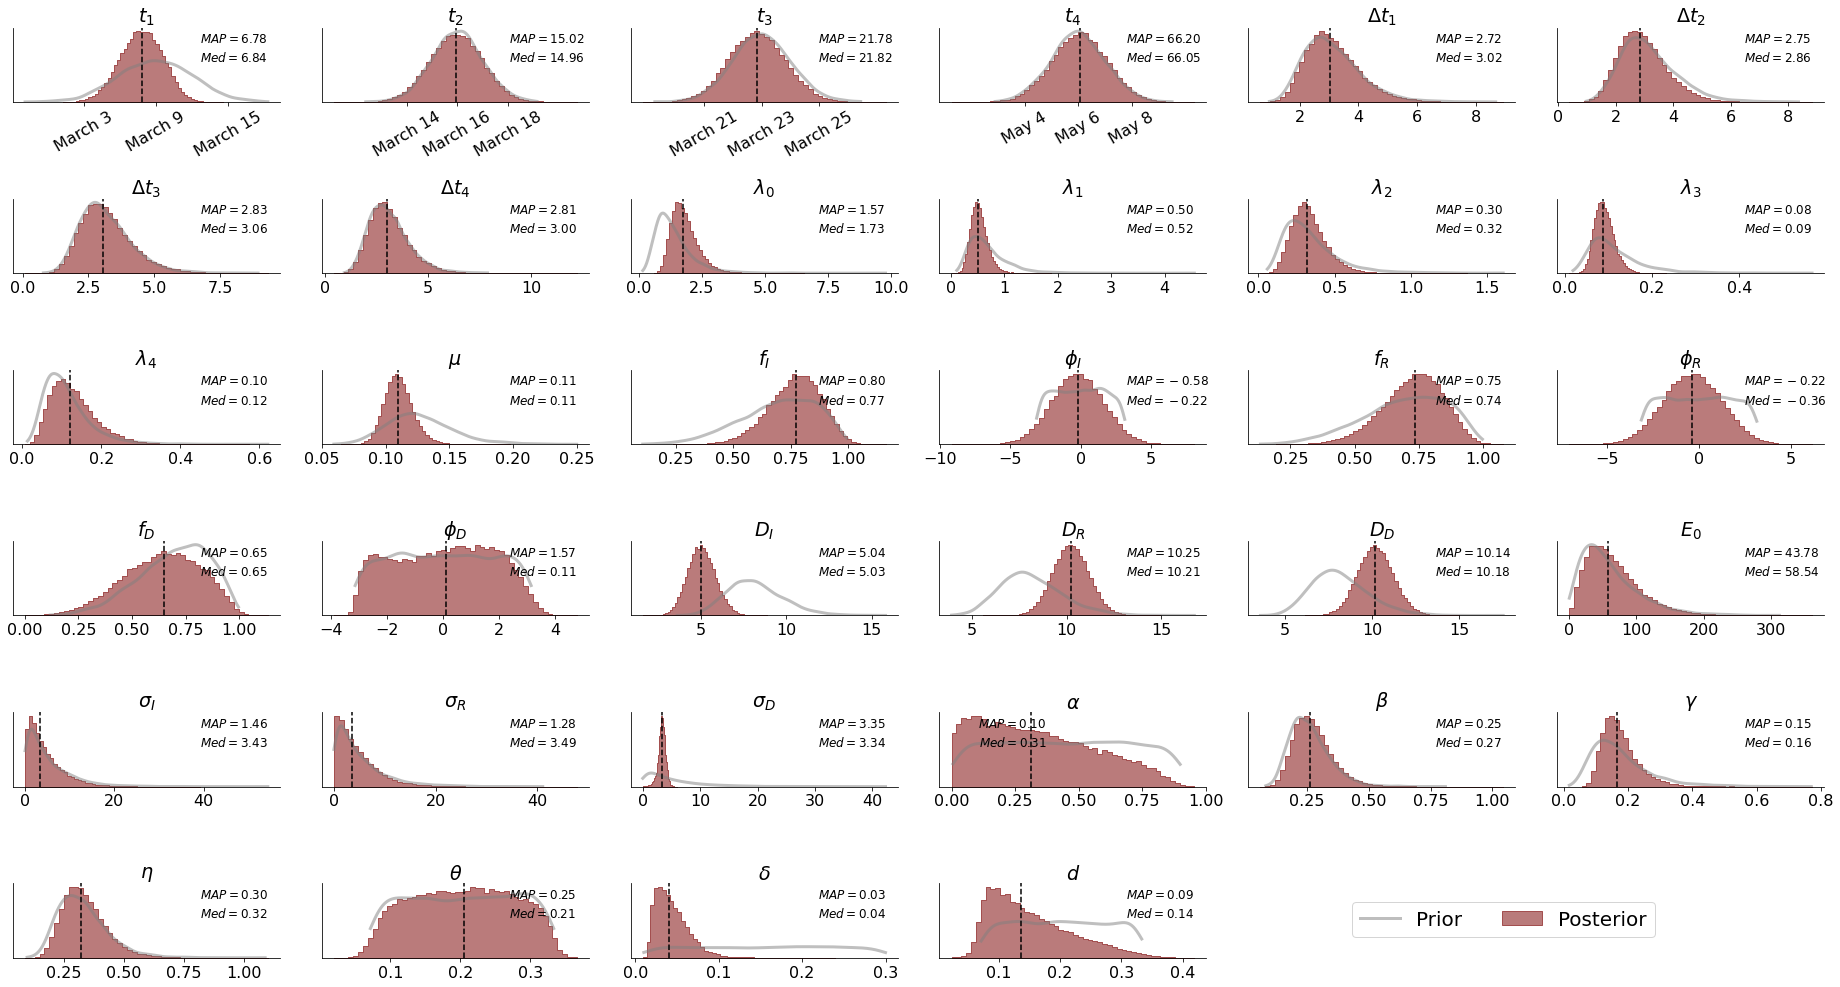

In [48]:
plot_posteriors_germany(50000, 
                        data_germany_tensor, 
                        bins=50, figsize=(26, 14), 
                        filename='Marginal_Posteriors_Germany_AblationConv', 
                        map_samples=10000)

In [51]:
param_tex = ['$t_1$', '$t_2$', '$t_3$', '$t_4$',
             '$\Delta t_1$', '$\Delta t_2$', '$\Delta t_3$', '$\Delta t_4$',
               '$\lambda_0$', '$\lambda_1$', '$\lambda_2$', '$\lambda_3$', '$\lambda_4$', 
               '$\mu$', '$f_I$', '$\phi_I$',  '$f_R$', '$\phi_R$',  
               '$f_D$', '$\phi_D$',
               '$D_I$', '$D_R$', '$D_D$', '$E_0$', '$\sigma_I$', '$\sigma_R$', '$\sigma_D$', 
               '$\alpha$', '$\beta$', '$\gamma$',
               '$\eta$', '$\theta$', '$\delta$', r'$d$']

## Simulation-based calibration

In [24]:
def plot_sbc(theta_samples, theta_test, param_names, bins=25,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])
    

    f, axarr = plt.subplots(6, 6, figsize=figsize)
    axarr = axarr.flat

    # Convert theta test to numpy
    theta_test = theta_test.numpy()

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.distplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f',
                         hist_kws=dict(edgecolor="k", linewidth=1,alpha=1.), bins=bins)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == 0:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
    
    axarr[j+1].axis('off')
    axarr[j+2].axis('off')
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_Entire.png".format(filename), dpi=300)

In [1]:
test_data_sbc = data_gen(5000)
theta_samples = np.concatenate([model.sample(x, 250, to_numpy=True) 
                                for x in tf.split(test_data_sbc['x'], 10, axis=0)], axis=1)

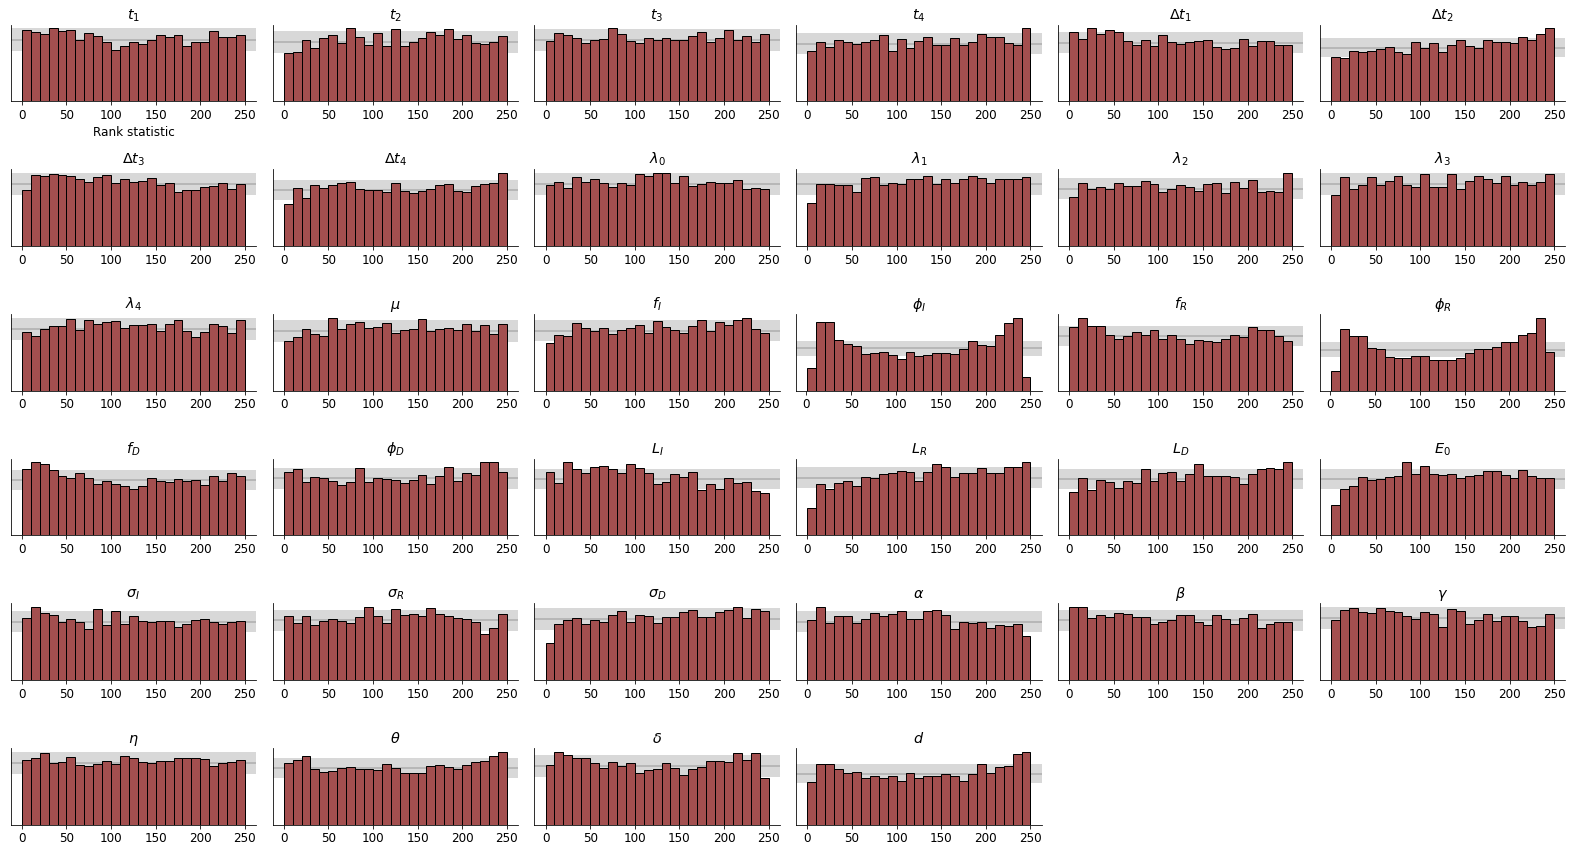

In [26]:
plot_sbc(theta_samples, 
         test_data_sbc['theta'], 
         param_names, 
         bins=25,
         figsize=(22, 12), 
         filename='SBC_AblationCov')

## Predictions on future data

In [27]:
def plot_predictions_future(n_samples, 
                            data, 
                            data_pred,
                            N_sim, 
                            T,
                            logscale=True, 
                            sim_diff=16, 
                            plot_quantiles=True, 
                            figsize=(24, 8), 
                            cumulative=False,
                            filename=None,
                            font_size=18):
    """Plots the posterior predictive."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    norm_data = (data - mean_g) / std_g 
    samples = model.sample(norm_data, n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if e != '$\\phi_I$' and e != '$\\phi_D$' and e != '$\\phi_R$']
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    print('Number of valid samples: ', samples.shape[0])
    f, ax = plt.subplots(1, 3, figsize=figsize)
    sims = []
    rej = 0
    for i in range(samples.shape[0]): 
        try:
            sim_cases = non_stationary_SEICR(samples[i, :-7], samples[i, -7:], N_sim, T, sim_diff=sim_diff)
            sims.append(sim_cases)
        except:
            rej += 1
    sims = np.array(sims)
    print('Number of rejected simulations: ', rej)
    
    if cumulative:
        sims = np.cumsum(sims, axis=1)
    meds = np.median(sims, axis=0)
    if cumulative:
        titles = ['Cumulative Infected', 'Cumulative Recovered', 'Cumulative Dead']
    else:
        titles = ['New Infected', 'New Recovered', 'New Dead']
        
    colors = ['Blue', 'Green', '#911a20']
    
    # Compute quantiles
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    
    for i in range(3):
        if cumulative:
            ax[i].plot(np.cumsum(data_pred[:, i], axis=0), 
                       marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
        else:
            ax[i].plot(data_pred[:, i], marker='o', 
                       label='Reported cases', 
                       color='black', linestyle='dashed', alpha=0.8)
        
        ax[i].axvline(data.numpy()[0, :, i].shape[0], color='black', alpha=0.8, linestyle='dotted')
        
        # Plot median cases
        ax[i].plot(meds[:, i], label='Median predicted cases', color=colors[i], lw=3)
        
        if plot_quantiles:
            ax[i].fill_between(range(T), qs_50[0, :, i], qs_50[1, :, i], color=colors[i], alpha=0.3, label='50% CI')
            ax[i].fill_between(range(T), qs_90[0, :, i], qs_90[1, :, i], color=colors[i], alpha=0.2, label='90% CI')
            ax[i].fill_between(range(T), qs_95[0, :, i], qs_95[1, :, i], color=colors[i], alpha=0.1, label='95% CI')
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], pad=0.2)
        ax[i].spines['top'].set_visible(False)
        ax[i].set_xlabel('Days')
        ax[i].set_ylabel('Number of cases')
        ax[i].legend(loc='upper left')
        ax[i].set_ylim([0, np.max(qs_95[1, :, i])*1.5])
        ax[i].set_xticks([6, 20, 34, 48, 62, 76, 90])
        ax[i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        ax[i].set_xticklabels(['Mar 8', 'Mar 22', 'Apr 5', 'Apr 19', 'May 3', 'May 17', 'May 31'], rotation=45)
        ylabels = ['{:,.1f}'.format(x) + 'K' for x in ax[i].get_yticks()/1000]
        ax[i].set_yticklabels(ylabels)
        
        if logscale:
            ax[i].set_yscale('log')
    f.tight_layout()
    plt.show()
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300)

In [28]:
date_data_begin = datetime.date(2020,3,1)
date_data_end_f = datetime.date(2020,6,11)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end_f = format_date(date_data_end_f)

cases_obs_f =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end_f])[0]
recovered_obs_f =  np.array(
    recovered_cases.loc[recovered_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end_f])[0]
dead_obs_f =  np.array(
    dead_cases.loc[dead_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end_f])[0]

data_germany_f = np.stack([cases_obs_f, recovered_obs_f, dead_obs_f]).T
data_germany_f = np.diff(data_germany_f, axis=0)
T_f = data_germany_f.shape[0]

Number of valid samples:  4766
Number of rejected simulations:  26


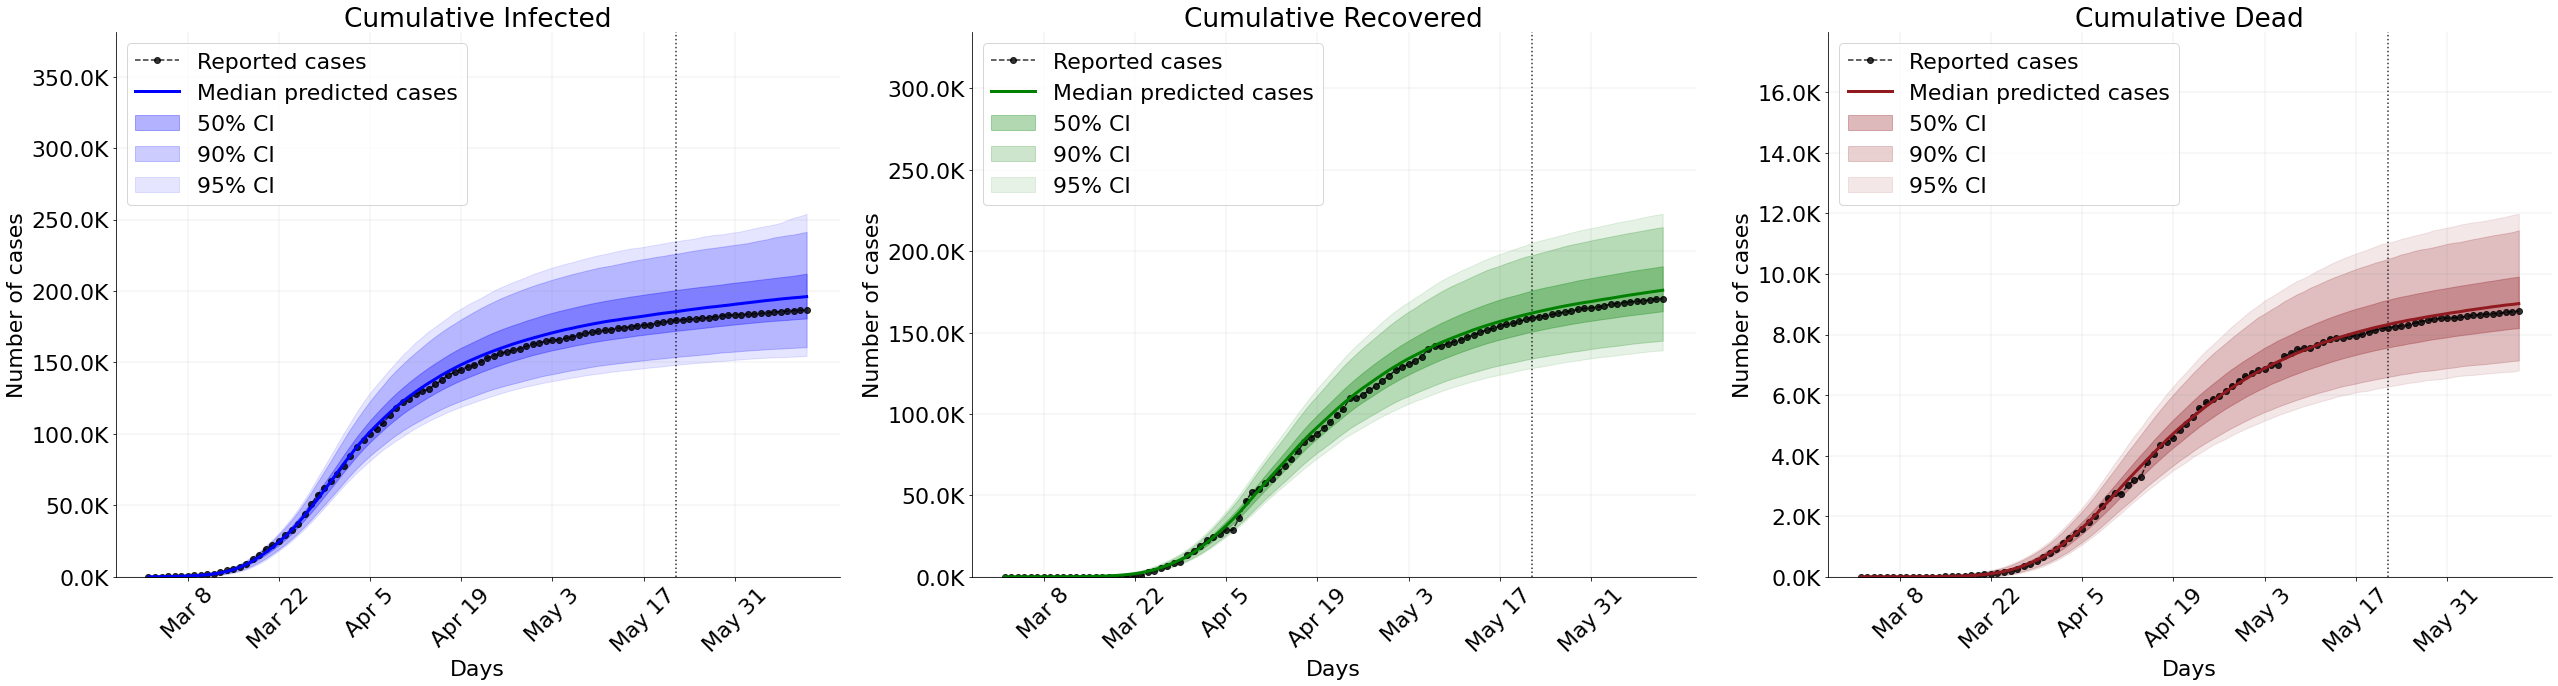

In [61]:
plot_predictions_future(5000, 
                 data_germany_tensor, 
                 data_germany_f,
                 N_germany, 
                 T_f,
                 logscale=False, 
                 sim_diff=16, 
                 cumulative=True, 
                 figsize=(36, 10), 
                 font_size=22,
                 filename='Predicted_Cumulative_AblationConv')

Number of valid samples:  4791
Number of rejected simulations:  29


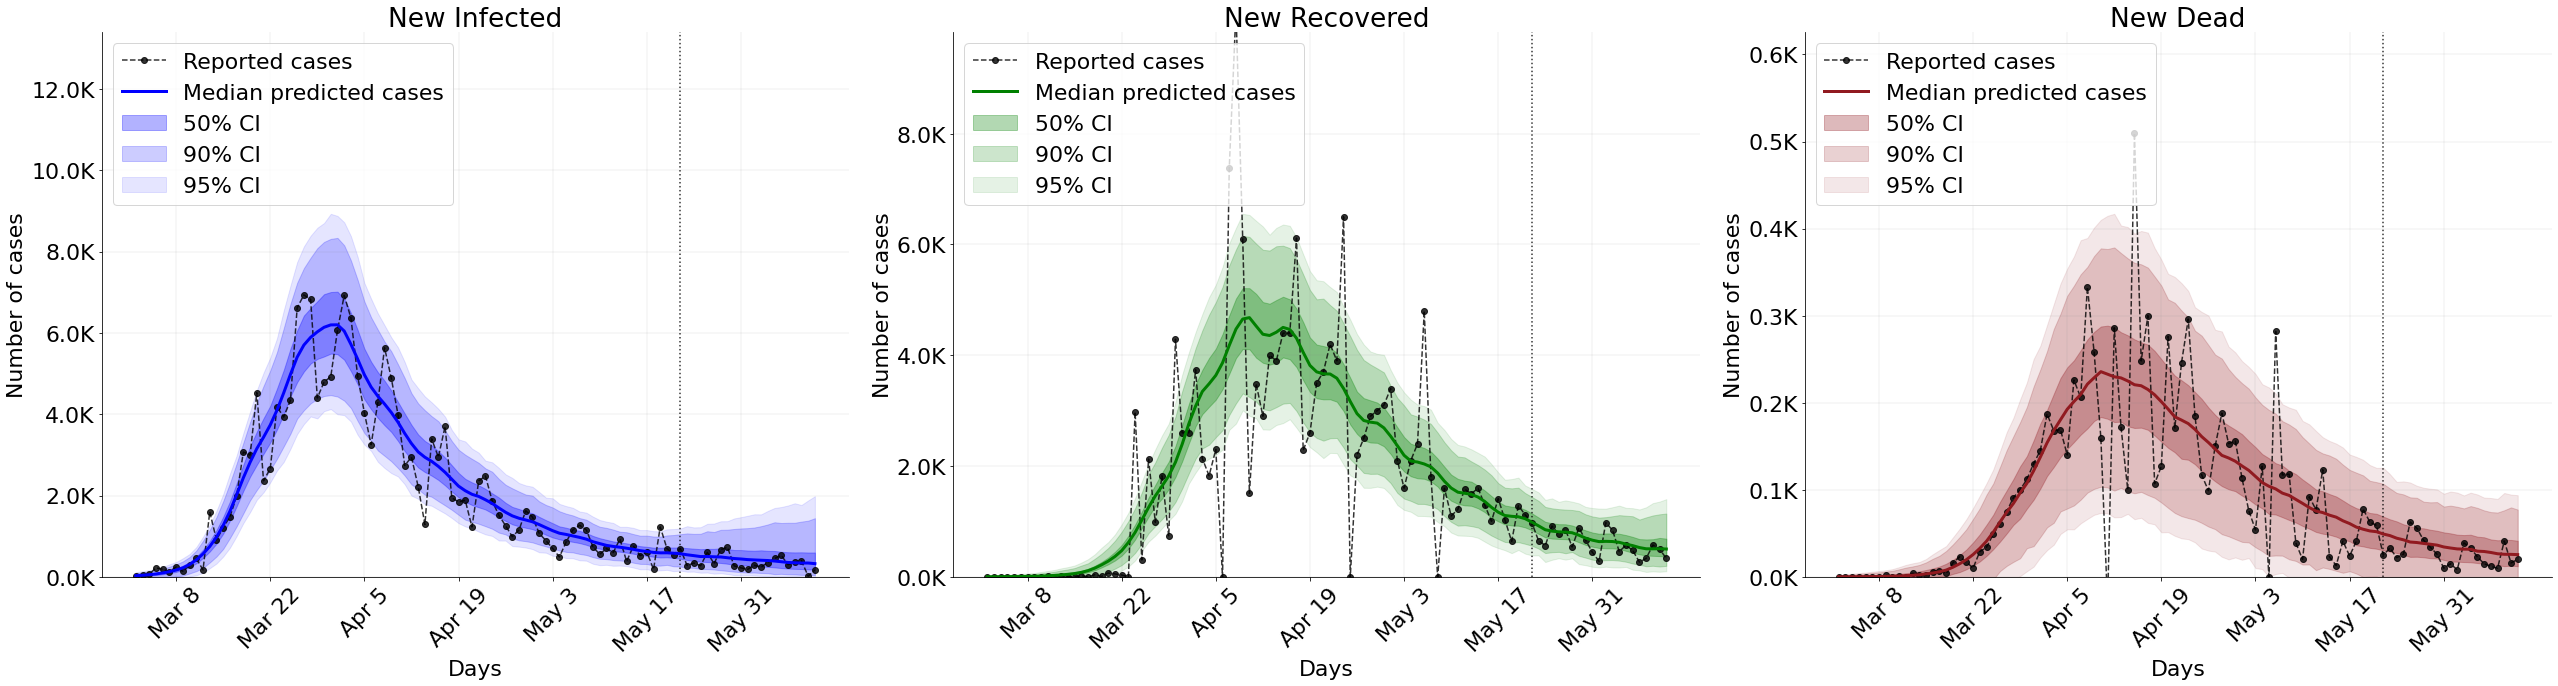

In [29]:
plot_predictions_future(5000, 
                 data_germany_tensor, 
                 data_germany_f,
                 N_germany, 
                 T_f,
                 logscale=False, 
                 sim_diff=16, 
                 cumulative=False, 
                 figsize=(36, 10), 
                 font_size=22,
                 filename='Predicted_New_AblationConv')